## Week 12 Homework (10)

### Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

- **Gaussian Processes (GPs) and stochastic processes generally**  
  A **stochastic process** is a collection of random variables indexed over time or space, used to describe systems that evolve with uncertainty.  
  A **Gaussian Process (GP)** is a type of stochastic process where any finite subset of random variables has a joint multivariate normal distribution. A GP is fully specified by:  
  - A mean function $\mu(x) = \mathbb{E}[f(x)]$  
  - A covariance function $k(x, x') = \text{Cov}(f(x), f(x'))$  
  GPs are used in machine learning for **non-parametric Bayesian regression and classification**, offering predictions along with uncertainty estimates.

- **Variational inference using the Evidence Lower Bound (ELBO)**  
  **Variational Inference (VI)** is a method for approximating complex posterior distributions by selecting a simpler distribution $q(z)$ and optimizing it to be close to the true posterior $p(z \mid x)$.  
  Direct computation of $p(z \mid x)$ is often intractable, so VI maximizes the **Evidence Lower Bound (ELBO)**:  
  $$
  \log p(x) \geq \mathbb{E}_{q(z)}[\log p(x \mid z)] - \text{KL}(q(z)\|p(z))
  $$  
  The ELBO includes:  
  - **Expected log-likelihood**: Measures how well $q(z)$ explains the observed data.  
  - **KL divergence**: Penalizes $q(z)$ for straying from the prior $p(z)$.  
  Maximizing the ELBO enables efficient and scalable posterior inference.


### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.



/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

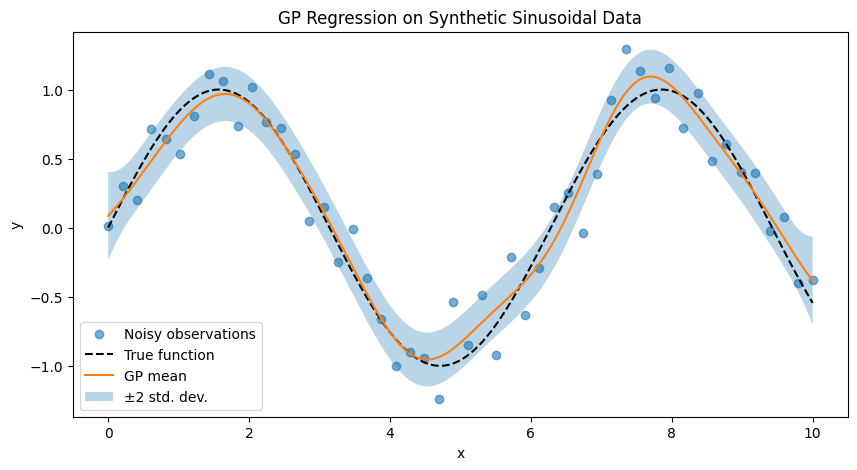

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

np.random.seed(4)
X = np.linspace(0, 10, 50)
y_true = np.sin(X)
y = y_true + np.random.normal(0, 0.2, size=X.shape)  # Add noise

X = X[:, None]

with pm.Model() as model:
    mean_func = pm.gp.mean.Zero()
    cov_func = pm.gp.cov.ExpQuad(1, ls=1.0)

    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    sigma = pm.HalfNormal("sigma", sigma=1)

    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)

    trace = pm.sample(1000, chains=2, target_accept=0.9)

X_new = np.linspace(0, 10, 200)[:, None]
with model:
    mu, var = gp.predict(X_new, point=trace.posterior.mean(dim=["chain", "draw"]), diag=True)
    sd = np.sqrt(var)

plt.figure(figsize=(10, 5))
plt.plot(X, y, 'o', label='Noisy observations', alpha=0.6)
plt.plot(X_new, np.sin(X_new), 'k--', label='True function')
plt.plot(X_new, mu, label='GP mean')
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, alpha=0.3, label='±2 std. dev.')
plt.title("GP Regression on Synthetic Sinusoidal Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

Output()

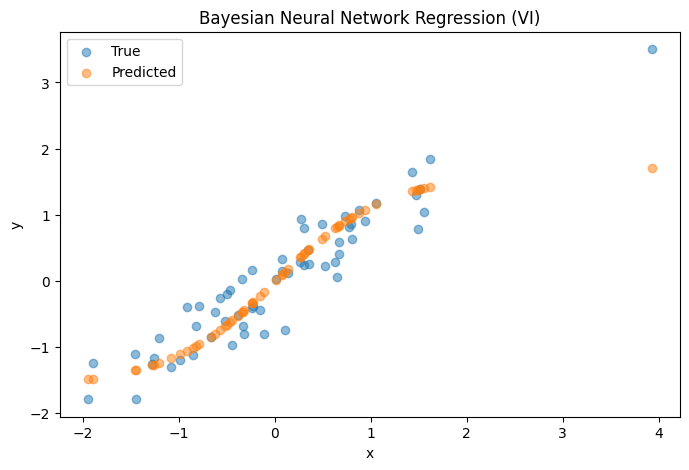

In [8]:


import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import arviz as az

X, y = make_regression(n_samples=300, n_features=1, noise=10, random_state=42)
X = X.astype(np.float32)
y = y.astype(np.float32)
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

with pm.Model() as model:
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(1, 10))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(10,))
    h1 = pt.tanh(pt.dot(X_train, w1) + b1)

    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(10, 1))
    b2 = pm.Normal("b2", mu=0, sigma=1, shape=(1,))
    out = pt.dot(h1, w2) + b2

    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=pt.flatten(out), sigma=sigma, observed=y_train)

    approx = pm.fit(n=20000, method="advi")

with model:
    posterior = approx.sample(500)

w1_post = posterior.posterior["w1"].mean(dim=("chain", "draw")).values
b1_post = posterior.posterior["b1"].mean(dim=("chain", "draw")).values
w2_post = posterior.posterior["w2"].mean(dim=("chain", "draw")).values
b2_post = posterior.posterior["b2"].mean(dim=("chain", "draw")).values


h1_test = np.tanh(X_test @ w1_post + b1_post)
y_pred = h1_test @ w2_post + b2_post
y_pred = y_pred.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, label="True", alpha=0.5)
plt.scatter(X_test, y_pred, label="Predicted", alpha=0.5)
plt.title("Bayesian Neural Network Regression (VI)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
